In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [2]:
sourcePoints = np.array([[0, 0], [10, 0], [10, 5], [5, 5], [5, 10], [0, 10],[0, 0]], dtype=float)
offset = 1.0
numberEndPoints = 10

In [3]:
import pyclipper

def offsetPolygon(polygonPoints, offset):
    clipper_offset = pyclipper.PyclipperOffset()
    clipper_offset.AddPath(polygonPoints, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
    clipperPoints = clipper_offset.Execute(offset)
    offsetPoints = np.array(clipperPoints[0])
    offsetPoints = np.append(offsetPoints, [offsetPoints[0]], axis=0)
    return offsetPoints

In [4]:
import collections

epsilon = 1e-8

def lengthPolygon(polygonPoints):
    startPoints = polygonPoints[:polygonPoints.shape[0]-1,:2]
    endPoints = polygonPoints[1:polygonPoints.shape[0],:2]
    length = np.sqrt((startPoints[:,0] - endPoints[:,0])**2 + (startPoints[:,1] - endPoints[:,1])**2).sum()
    return length

def normalize(vector):
    return vector / np.linalg.norm(vector)

def pointIsWithin(startPoint, endPoint, checkPoint):
    checkToStart = checkPoint - startPoint
    if np.linalg.norm(checkToStart) < epsilon:
        return True
    checkToEnd = checkPoint - endPoint
    if np.linalg.norm(checkToEnd) < epsilon:
        return True
    return np.dot(checkToStart, checkToEnd) < 0
        
def calculateIntersection(startPoint, endPoint, centerPoint, distance):
    #print('startPoint:', startPoint)
    #print('endPoint:', endPoint)
    #print('centerPoint:', centerPoint)
    #print('distance:', distance)
    IntersectionPoint = collections.namedtuple('IntersectionPoint', ['x', 'y', 'hasIntersection'])
    direction = normalize(endPoint - startPoint)
    #print('Direction:', direction)
    startToCenter = centerPoint - startPoint
    #print('startToCenter:',startToCenter)
    closestPoint = startPoint
    if np.linalg.norm(startToCenter) > epsilon:
        scalar = np.dot(direction, startToCenter)
        closestPoint = startPoint + (scalar * direction)
    distanceToClosestPoint = np.linalg.norm(closestPoint - centerPoint)
    if (np.abs(distance - distanceToClosestPoint) < epsilon):
        # Nur 1-Punktlösung => Nur closestPoint ist zu prüfen
#        print('1 Schnittpunkt')
        hasIntersection = pointIsWithin(startPoint, endPoint, closestPoint)
        return IntersectionPoint(closestPoint[0], closestPoint[1], hasIntersection)
    elif (distanceToClosestPoint < distance):
        # 2-Punktlösung => Beide Schnittpnkte prüfen
#        print('2 Schnittpunkte')
        # Sonderfall centerPoint auf Linie
        if np.abs(distanceToClosestPoint) < epsilon:
#            print('Sonderfall centerPoint auf Linie')
            point1 = closestPoint + distance * direction
            hasIntersection = pointIsWithin(startPoint, endPoint, point1)
            return IntersectionPoint(point1[0], point1[1], hasIntersection) 
        else:
            delta = np.sqrt(distance**2 - distanceToClosestPoint**2)
            point1 = closestPoint + delta * direction
            hasIntersection = pointIsWithin(startPoint, endPoint, point1)
            if hasIntersection:
                return IntersectionPoint(point1[0], point1[1], hasIntersection) 
            point2 = closestPoint - delta * direction
            hasIntersection = pointIsWithin(startPoint, endPoint, point2)
            return IntersectionPoint(point2[0], point2[1], hasIntersection) 
    else:
        # Abstand zu groß => Kein Schnittpunkt innerhalb von distance
#        print('Kein Schnittpunkt')
        return IntersectionPoint(0, 0, False)
    
    return IntersectionPoint(0, 0, False)

def calculateEndPointsPerDistance(polygonPoints, distance):
    endPoints = np.array([polygonPoints[0]])
    for i in range(0, polygonPoints.shape[0]-1):
        #print()
        hasIntersection = True
        while hasIntersection:
            intersection = calculateIntersection(polygonPoints[i], polygonPoints[i+1], endPoints[-1], distance)
            #print('intersection:', intersection)
            hasIntersection = intersection.hasIntersection
            if hasIntersection:
                endPoints = np.append(endPoints, [[intersection.x, intersection.y]], axis=0)
    endPoints = np.append(endPoints, [polygonPoints[-1]], axis=0)
    return endPoints

def calculateEndPoints(polygonPoints, numberOfTargetPoints):
    print('numberOfTargetPoints:',numberOfTargetPoints)
    polygonLength = lengthPolygon(polygonPoints)
    print('Polygonlänge:', polygonLength)
    startDistance = polygonLength / numberOfTargetPoints
    print('Startabstand:', startDistance)
     
    lowerDistance = 0
    upperDistance = startDistance
    nextDistance = (upperDistance + lowerDistance) / 2
    for i in range(0,100):
        #print('lowerDistance:',lowerDistance)
        #print('upperDistance:',upperDistance)
        currentDistance = nextDistance
        print('currentDistance:',currentDistance)
        endPoints = calculateEndPointsPerDistance(polygonPoints, currentDistance)
        #print('endPoints:', endPoints)
        numberOfPoints = endPoints.shape[0]-2 + np.linalg.norm(endPoints[-1] - endPoints[-2]) / startDistance
        print('####################### numberOfPoints:', numberOfPoints)
        if (np.abs(numberOfPoints - numberOfTargetPoints) < 0.001):
            break;
        if numberOfPoints > numberOfTargetPoints:
            lowerDistance = currentDistance
        else:
            upperDistance = currentDistance
        nextDistance = (upperDistance + lowerDistance) / 2
        if np.abs(nextDistance-currentDistance) < epsilon:
            #Intervallschachtelung bringt keine Veränderung mehr
            print('Intervallschachtelung bringt keine Veränderung mehr')
            break;
    if  (numberOfPoints > numberOfTargetPoints):
        #Entferne den vorletzten Punkt, da er fast dem letzten entspricht
        print('Entferne den vorletzten Punkt, da er fast dem letzten entspricht')
        endPoints[-2] = endPoints[-1]
        endPoints = endPoints[:endPoints.shape[0]-1,:]
    return endPoints

numberOfTargetPoints: 18
Polygonlänge: 48.0
Startabstand: 2.6666666666666665
currentDistance: 1.3333333333333333
####################### numberOfPoints: 35.125000072177606
currentDistance: 2.0
####################### numberOfPoints: 22.375947230530144
currentDistance: 2.333333333333333
####################### numberOfPoints: 20.010318871346346
currentDistance: 2.5
####################### numberOfPoints: 18.213683437035588
currentDistance: 2.583333333333333
####################### numberOfPoints: 16.93346182763055
currentDistance: 2.5416666666666665
####################### numberOfPoints: 17.719184100562103
currentDistance: 2.520833333333333
####################### numberOfPoints: 17.742450765835617
currentDistance: 2.5104166666666665
####################### numberOfPoints: 17.76303362228119
currentDistance: 2.505208333333333
####################### numberOfPoints: 17.78372820547371
currentDistance: 2.5026041666666665
####################### numberOfPoints: 17.80788016674244
currentDist

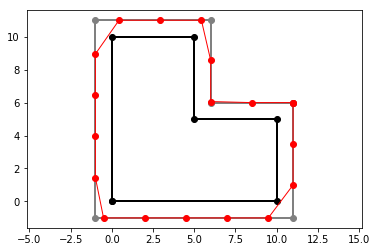

Brunnen:
 [[11.          6.        ]
 [ 8.4995931   6.        ]
 [ 6.          6.0637888 ]
 [ 6.          8.5641957 ]
 [ 5.43529471 11.        ]
 [ 2.93488781 11.        ]
 [ 0.43448091 11.        ]
 [-1.          8.95200117]
 [-1.          6.45159427]
 [-1.          3.95118737]
 [-1.          1.45078047]
 [-0.5043088  -1.        ]
 [ 1.9960981  -1.        ]
 [ 4.496505   -1.        ]
 [ 6.9969119  -1.        ]
 [ 9.4973188  -1.        ]
 [11.          0.99849541]
 [11.          3.49890231]
 [11.          6.        ]]


In [7]:
import matplotlib.lines as lines

offsetPoints = offsetPolygon(sourcePoints, offset)
targetPoints = calculateEndPoints(offsetPoints, 18)

fig, ax = plt.subplots()

sourceLines = lines.Line2D(sourcePoints[:,0], sourcePoints[:,1], lw=2, color='black', axes=ax, marker='o', markerfacecolor='black')
ax.add_line(sourceLines)
offsetLines = lines.Line2D(offsetPoints[:,0], offsetPoints[:,1], lw=2, color='grey', axes=ax, marker='o', markerfacecolor='grey')
ax.add_line(offsetLines)
targetLines = lines.Line2D(targetPoints[:,0], targetPoints[:,1], lw=1, color='red', axes=ax, marker='o', markerfacecolor='red')
ax.add_line(targetLines)

ax.autoscale()
plt.axis('equal')
plt.show()
print('Brunnen:\n', targetPoints)